# Ontake dv/v - Rain&Snow Correction Cookbook


In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>")) 
import datetime
import matplotlib
matplotlib.use('nbagg')

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 6) 

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.signal import detrend
from scipy.special import erf, erfc
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
sns.set_style("whitegrid")
sns.set_palette("bright")

In [2]:
pluvio = pd.read_csv(r"Kaida_2012-2014.csv",index_col=0, parse_dates=True, dayfirst=True)
pluvio["rate"] = pluvio["Precipitation (mm)"].ffill()

pluvio["load"] = 0.0
pluvio.loc[1:,"load"] = np.diff(pluvio["rate"]) * 9.81 * 1.0
pluvio

,Temperature (C),Quality 1,Quality 2,Precipitation (mm),Quality 1.1,Quality 2.1,Snow depth (cm),Quality 1.2,Quality 2.2,Snow fall (cm),Quality 1.3,Quality 2.3,rate,load
Y/M/D,,,,,,,,,,,,,,
2012-01-01,-5.5,8,1,0.0,8,1,9,8,1,0,8,1,0.0,0.000
2012-01-02,-3.3,8,1,0.0,8,1,12,8,1,3,8,1,0.0,0.000
2012-01-03,-4.7,8,1,0.0,8,1,11,8,1,4,8,1,0.0,0.000
2012-01-04,-5.2,8,1,4.0,8,1,21,8,1,14,8,1,4.0,39.240
2012-01-05,-7.4,8,1,2.5,8,1,29,8,1,9,8,1,2.5,-14.715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,-7.6,8,1,0.0,8,1,38,8,1,0,8,1,0.0,0.000
2014-12-28,-5.8,8,1,7.0,8,1,45,8,1,9,8,1,7.0,68.670
2014-12-29,-0.3,8,1,16.0,8,1,60,8,1,15,8,1,16.0,88.290


<IPython.core.display.Javascript object>


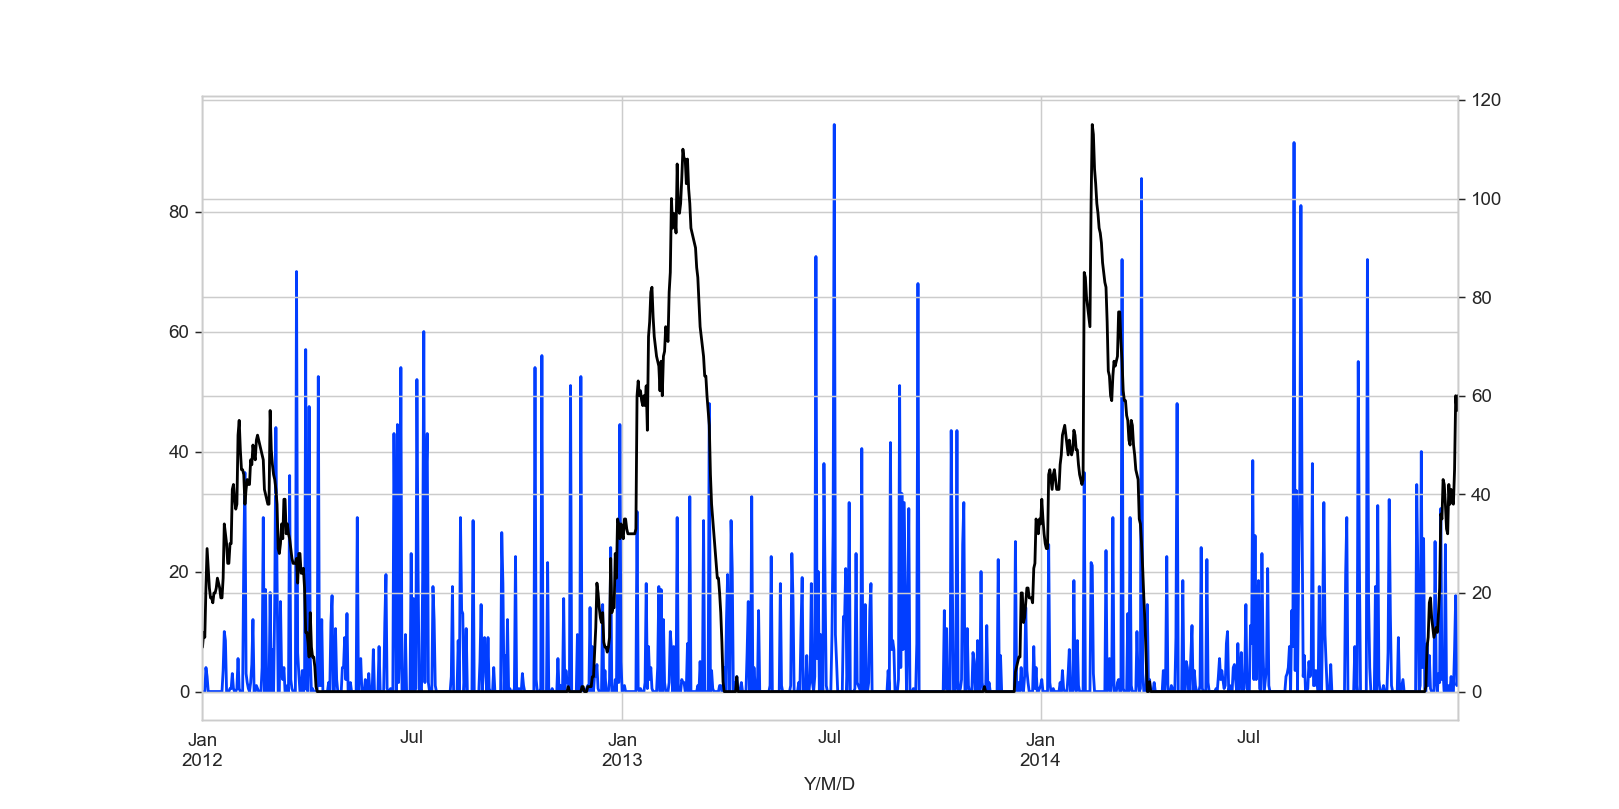

In [3]:
pluvio["rate"].plot()
plt.twinx()
pluvio["Snow depth (cm)"].plot(c='k')
plt.show()

## Computing pore pressure change diffusion P(t,r)

The dmin parameter is defined as 1000 m manually, it is a subjective decision,
in the future it should probably be optimised automatically too.

The final P(t) is the linear average of P(t,r).

In [5]:

c = 1.0
dt = 86400.0
dmin = 1000
dmax = 8000
dstep = 500
depths = np.arange(dmin, dmax+dstep, dstep)
pluvio["P"] = 0.0
for r in depths:
    pluvio["P%i"%r] = 0.0

for t in range(len(pluvio)):
    X = np.arange(t)
    vals = pluvio.iloc[X]["load"].values
    for r in depths:
        n = t
        func = r/np.sqrt(4.0*c*(n-X)*dt)
        # first part of Eq in Rivet, not used by Wang
    #     a = np.sum(alpha * vals * erf(func))
        b = np.sum(vals * erfc(func))
        pluvio.loc[pluvio.index[t],"P"] += b
        pluvio.loc[pluvio.index[t],"P%i"%r] = b

pluvio["P"] /= len(depths)

<IPython.core.display.Javascript object>


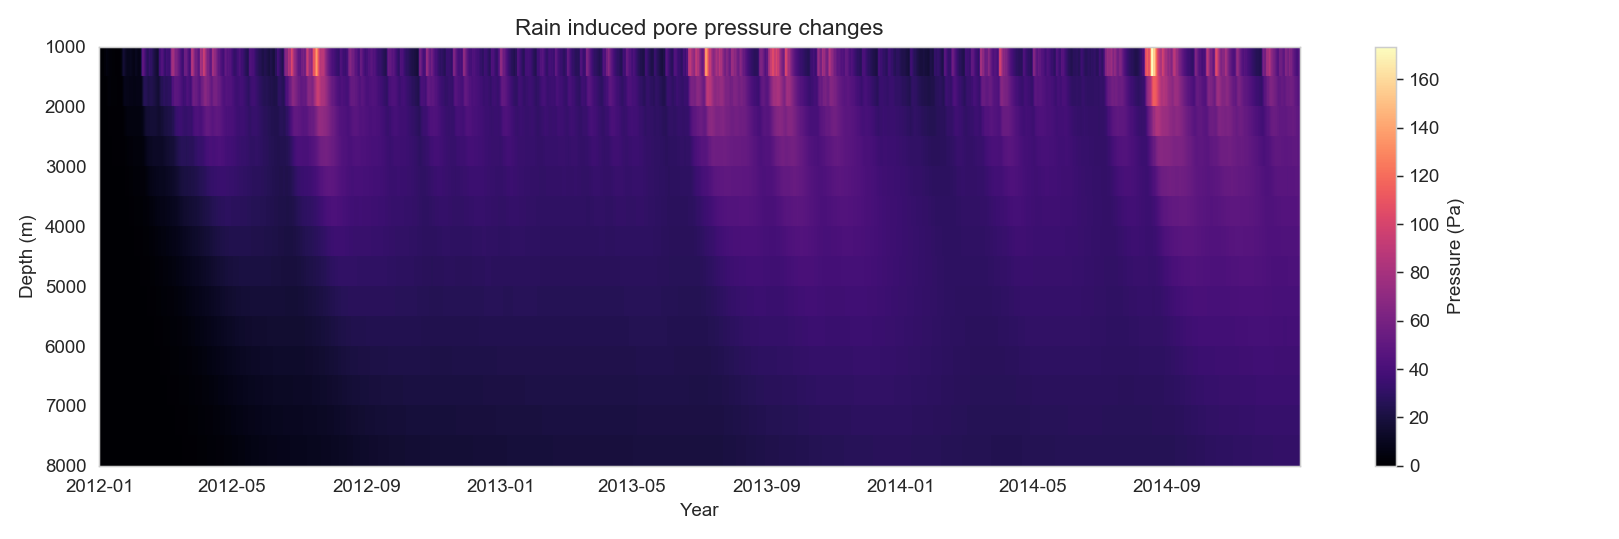

In [6]:
all = np.asarray([pluvio["P%i"%i] for i in depths])
plt.figure(figsize=(12,4))
plt.pcolormesh(pluvio["P"].index, depths, all, cmap="magma")
cb = plt.colorbar()
cb.set_label("Pressure (Pa)")
plt.gca().invert_yaxis()
plt.title("Rain induced pore pressure changes")
plt.ylabel("Depth (m)")
plt.xlabel("Year")

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


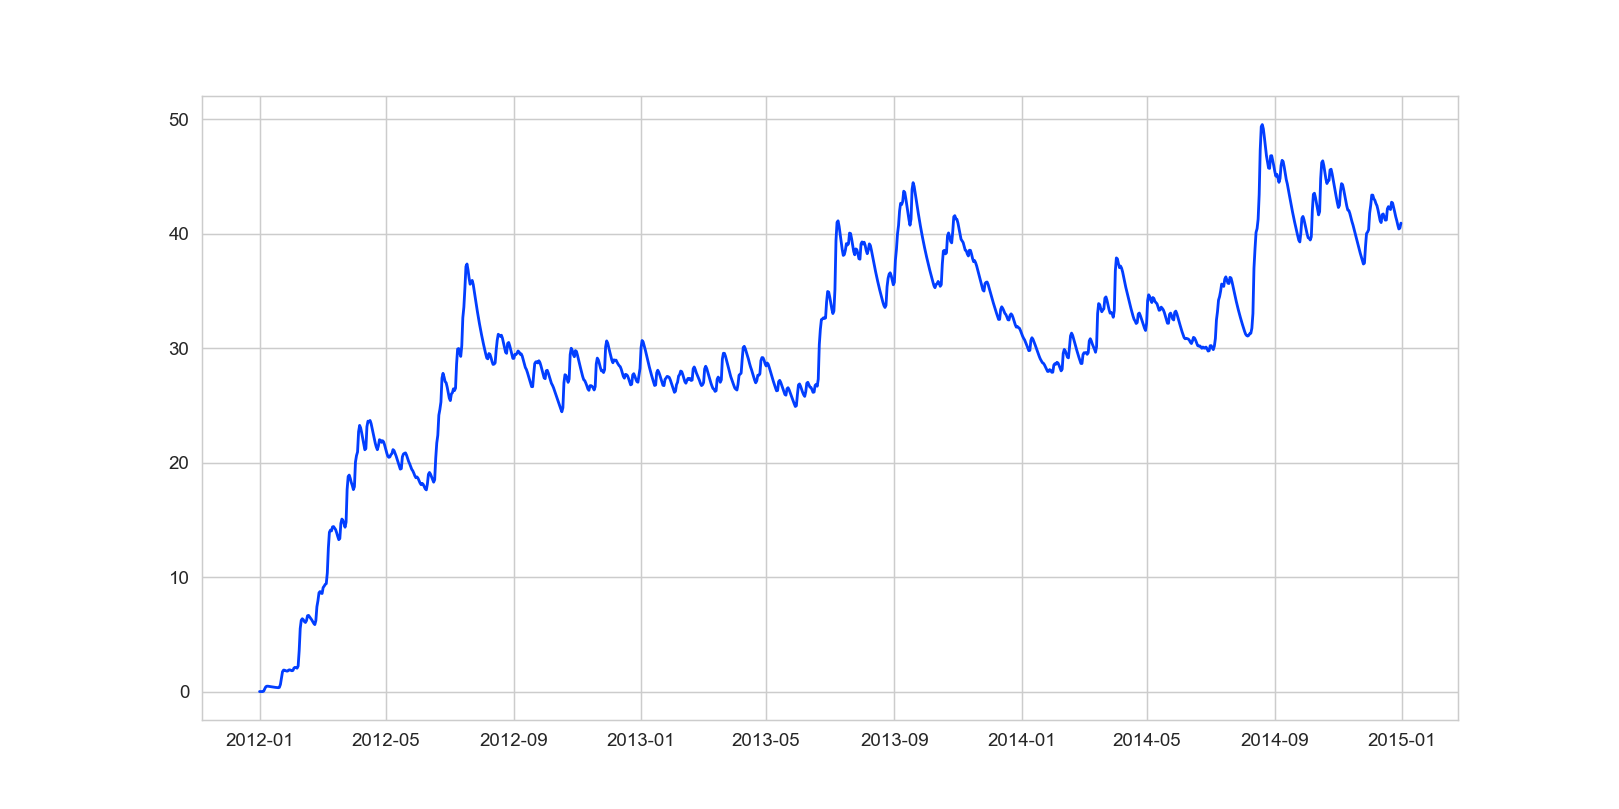

In [7]:
pluvio["P"] = all.mean(axis=0)
plt.plot(pluvio.index, pluvio["P"].values)
plt.show()

In [8]:
df = pd.read_csv("results_2014_09_28/2019-inversion-ONTA_ONTA-100000.0.csv", index_col=0, parse_dates=True,names=["date", "M"])
df = df.loc[pluvio.index[0]: pluvio.index[-1]].interpolate().ffill().bfill()
df["M"] -= df["M"][0]
df.tail()

,M
date,
2014-09-24,-0.011020
2014-09-25,-0.010388
2014-09-26,-0.009480
2014-09-27,-0.008281
2014-09-28,-0.007032


<IPython.core.display.Javascript object>


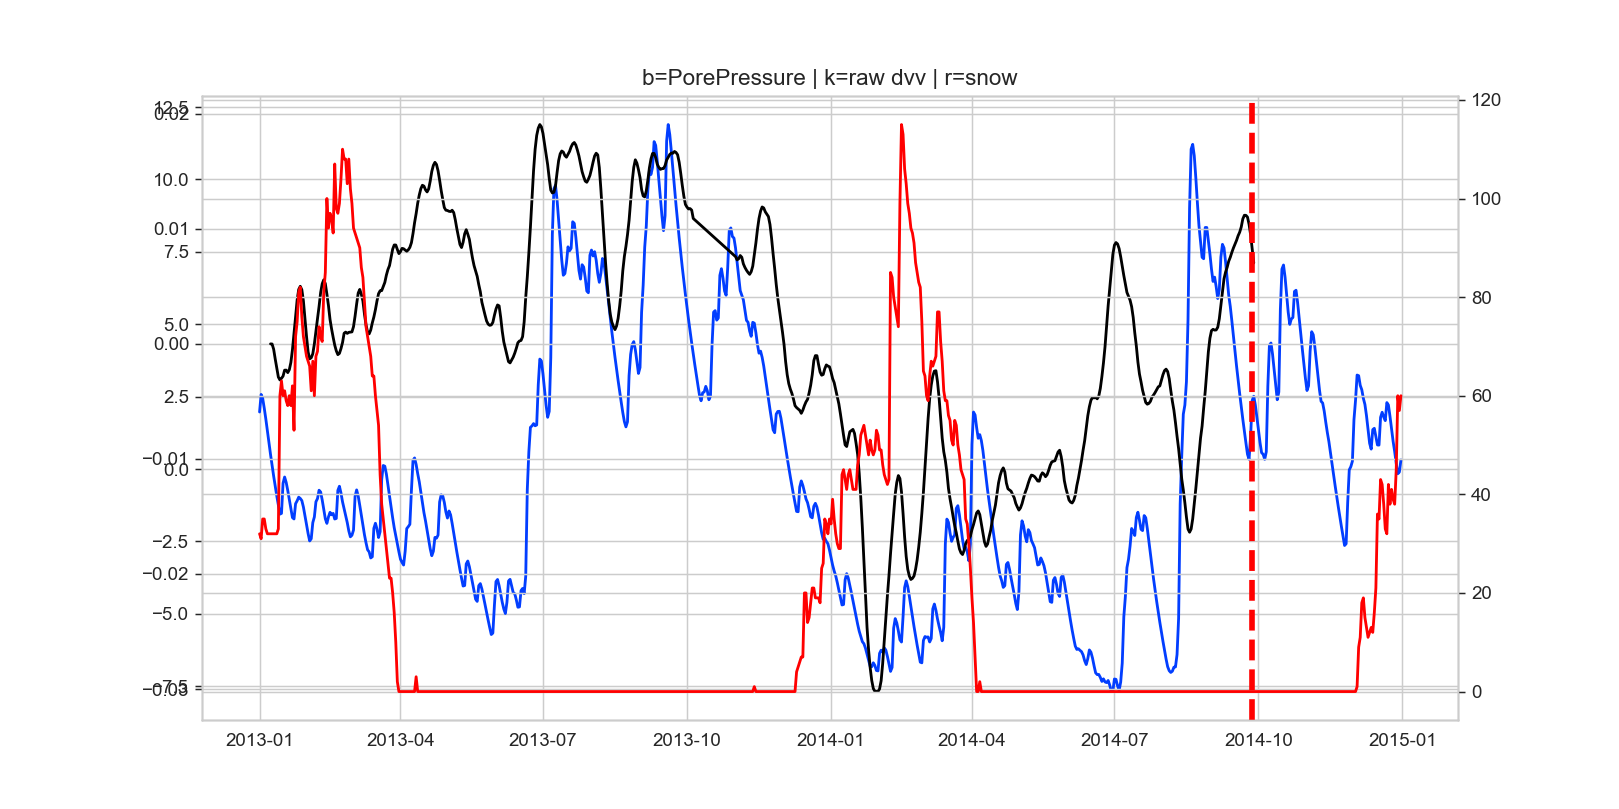

In [10]:
pluvio = pluvio.loc["2013-01-01":]
pluvio["P"] = detrend(pluvio["P"])

plt.plot(pluvio["P"].index, pluvio["P"])
plt.twinx()
plt.plot(df.index, -df["M"],c='k')
plt.twinx()
plt.plot(pluvio.index, pluvio["Snow depth (cm)"], c='r')
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3, ls='--')
plt.title("b=PorePressure | k=raw dvv | r=snow")
plt.show()

In [11]:
pluvio["dtt"] = df["M"] * -1.0

### Computing Wang's Eq(3) to obtain the P(t) vs dv/v_obs ratio

We do that on a visually well matching slice of the data (but including the long term seasonal bump)

In [12]:
pluvio = pluvio.dropna()
#modelled dv/v
sliced = pluvio[["P","dtt"]].loc["2013-03-01":"2014-05-01"].copy()
#sliced = pluvio[["P","dtt"]].loc["2013-03-01":"2013-06-01"].copy()

sliced["P"] = detrend(sliced["P"])
sliced["dtt"] = detrend(sliced["dtt"])
ratio = np.cov(sliced["dtt"], sliced["P"])[1,0] /  np.var(sliced["P"])
print(ratio)
predicted = sliced.dtt.mean() + ratio * (sliced["P"]-sliced["P"].mean())
print(1./ratio)

0.0014841268691286012
673.7968436533635


<IPython.core.display.Javascript object>


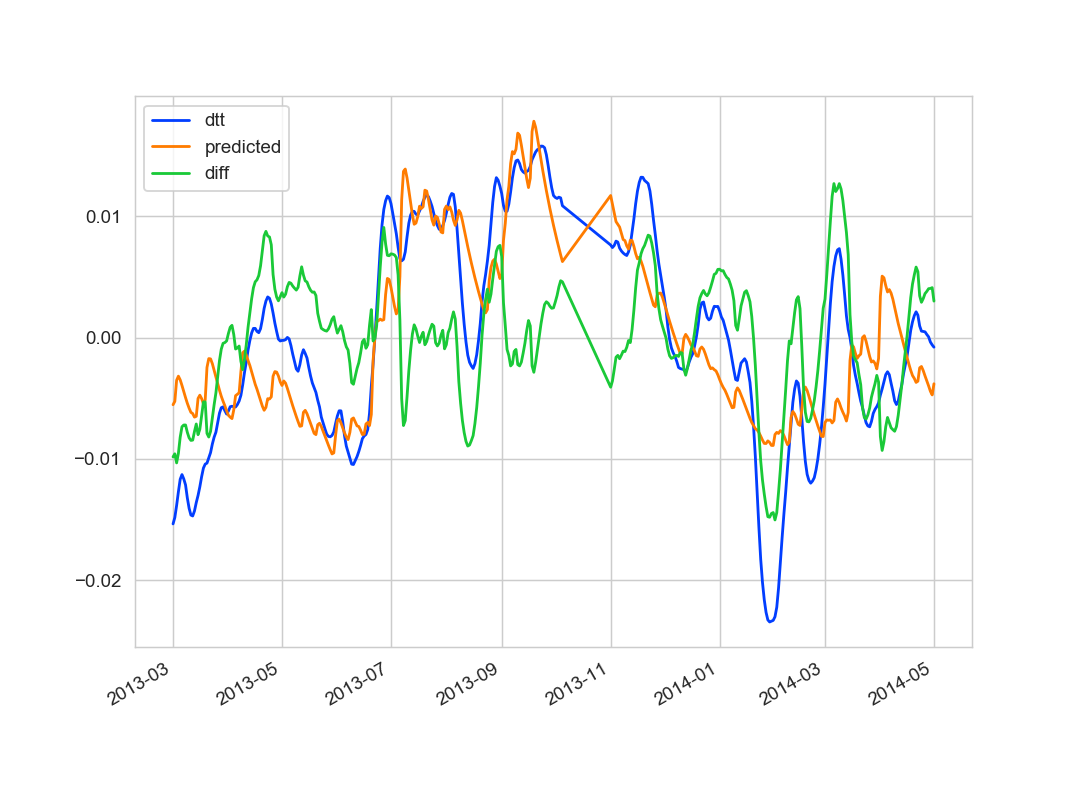

In [13]:
fig = plt.figure(figsize=(8,6))
plt.plot(sliced.index, sliced.dtt, label= 'dtt')
plt.plot(sliced.index, predicted, label ="predicted")
plt.plot(sliced.index, sliced.dtt - predicted, label='diff')
plt.legend()
fig.autofmt_xdate()
plt.show()

<IPython.core.display.Javascript object>


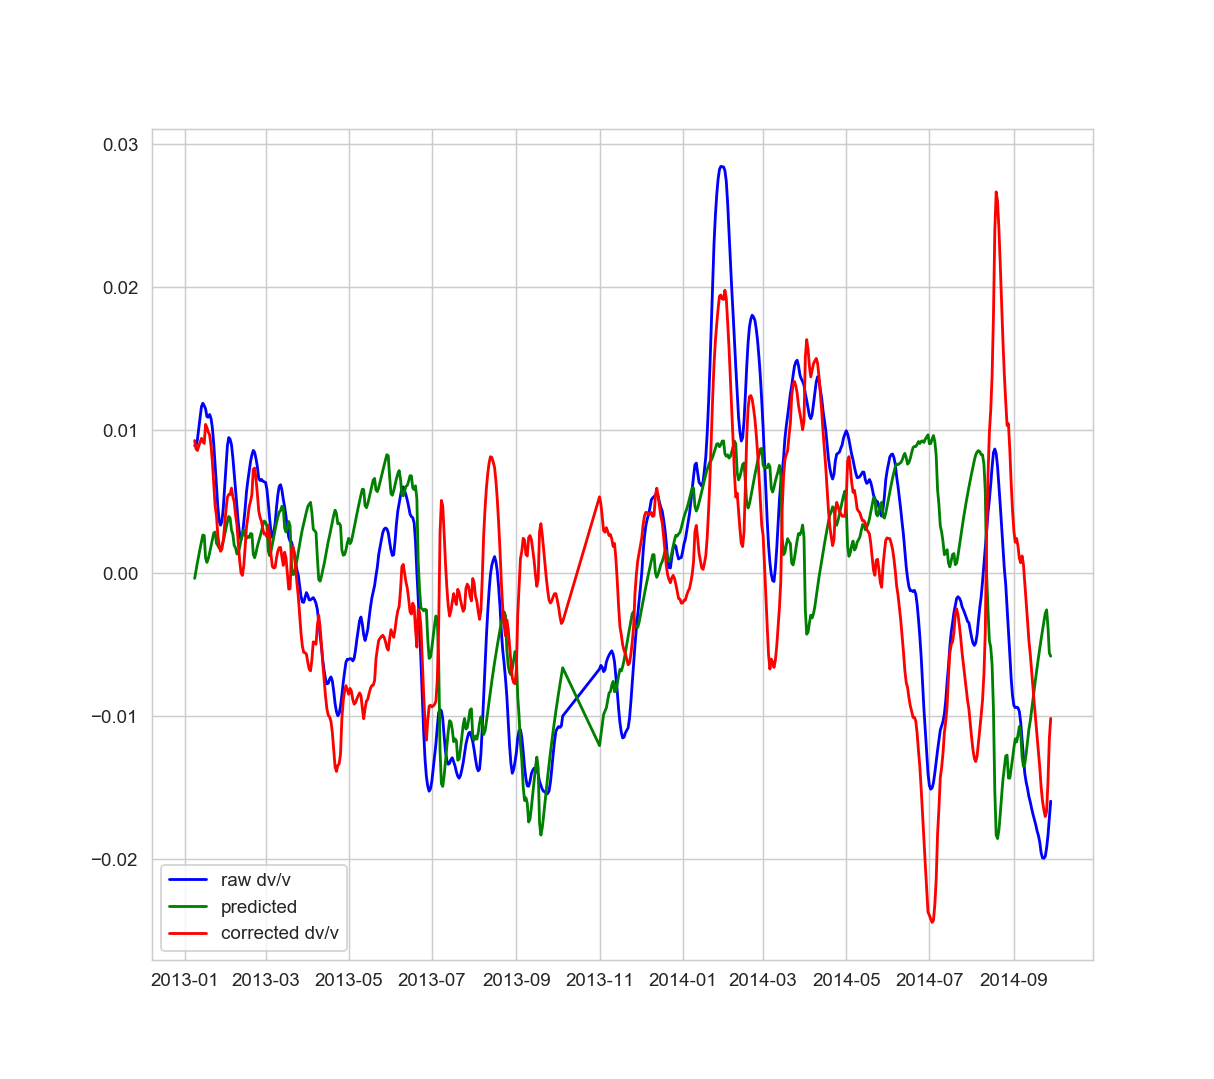

In [15]:
pluvio = pluvio.interpolate()
pluvio["P"] = detrend(pluvio["P"])
pluvio["dtt"] = detrend(pluvio["dtt"])
pluvio["predicted"] =  ratio * (pluvio["P"]-pluvio["P"].mean())

plt.figure(figsize=(9,8))
plt.plot(pluvio.index, -1*pluvio["dtt"], c="b", label="raw dv/v")
plt.plot(pluvio.index, -1*pluvio["predicted"], c="g", label="predicted")
plt.plot(pluvio.index, -1*pluvio["dtt"] - (-1*pluvio["predicted"]), c="r", label="corrected dv/v")

# plt.plot(pluvio.index, -1*(pluvio["dtt (-dvv)"] - pluvio.P*factor*2),c="g", label="rain corrected dv/v")
plt.legend(loc=3, frameon=True)

#plt.xlim(datetime.datetime(2011,1,1),datetime.datetime(2018,1,1),)
plt.show()

## Define a,b mixing parameters manually

<IPython.core.display.Javascript object>


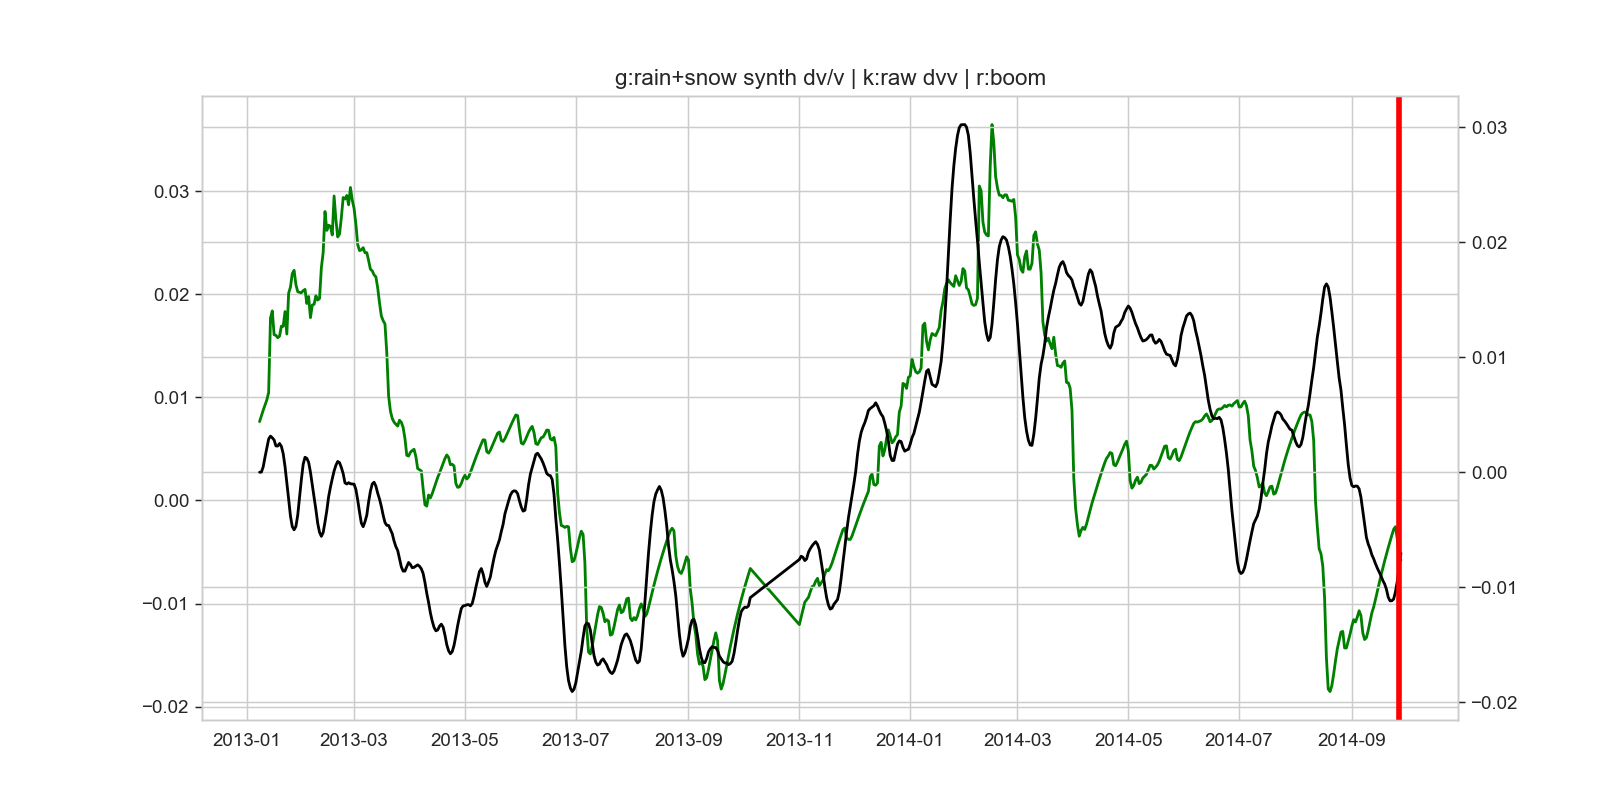

<IPython.core.display.Javascript object>


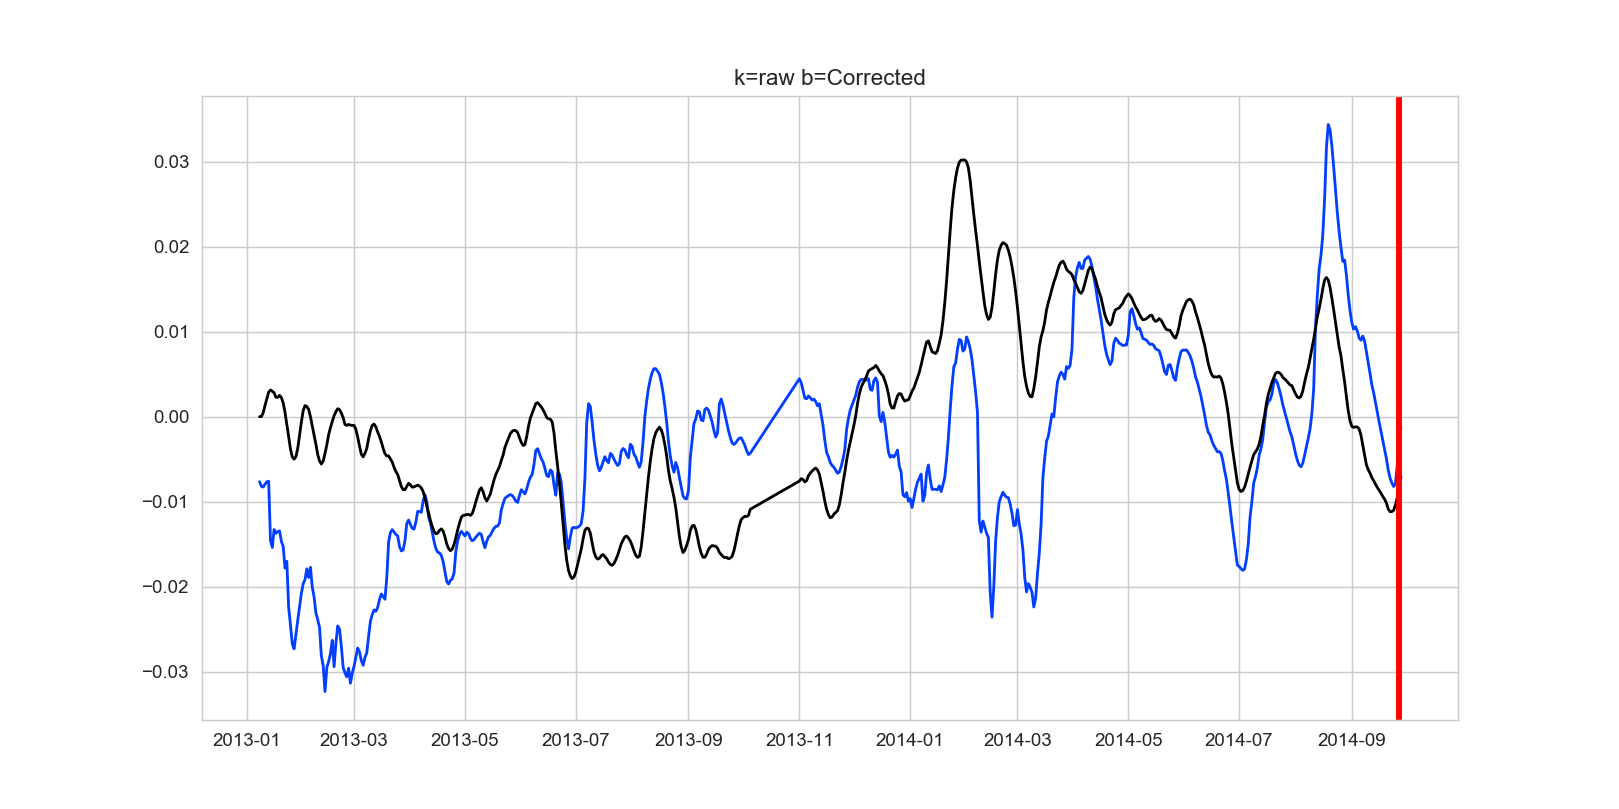

In [16]:
a = -1 #because we work with the "Predicted" dv/v, which includes the ratio computed above
b = 2.5e-4
C = 0


dvv = df["M"]
dvvsynth =  a * pluvio["predicted"] + b * pluvio["Snow depth (cm)"] + C

plt.plot(pluvio.index, dvvsynth , c="g", label="rain+snow synth dv/v")
plt.twinx()
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.show()

plt.plot(pluvio.index, dvv-dvvsynth )






plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=Corrected")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()


## Define a,b mixing parameters automatically by optimization

In this case, we don't have to define a "visually well matching time slice" of the data. All data are taken into account
in the optimization process.

In [17]:
from scipy.optimize import minimize

In [18]:
pluvio["P"] -= pluvio["P"].mean()
fun = lambda x: (((x[0] * pluvio["P"] + x[1] * pluvio["Snow depth (cm)"]) - pluvio["dtt"])**2).sum()
res = minimize(fun, [0.0, 0.0])
print(res)
a, b = res.x

      fun: 0.03245086185060428
 hess_inv: array([[4.04112537e-05, 1.61907548e-06],
       [1.61907548e-06, 6.95298572e-07]])
      jac: array([-4.65661287e-10,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([ 1.00183463e-03, -8.70542727e-05])


<IPython.core.display.Javascript object>


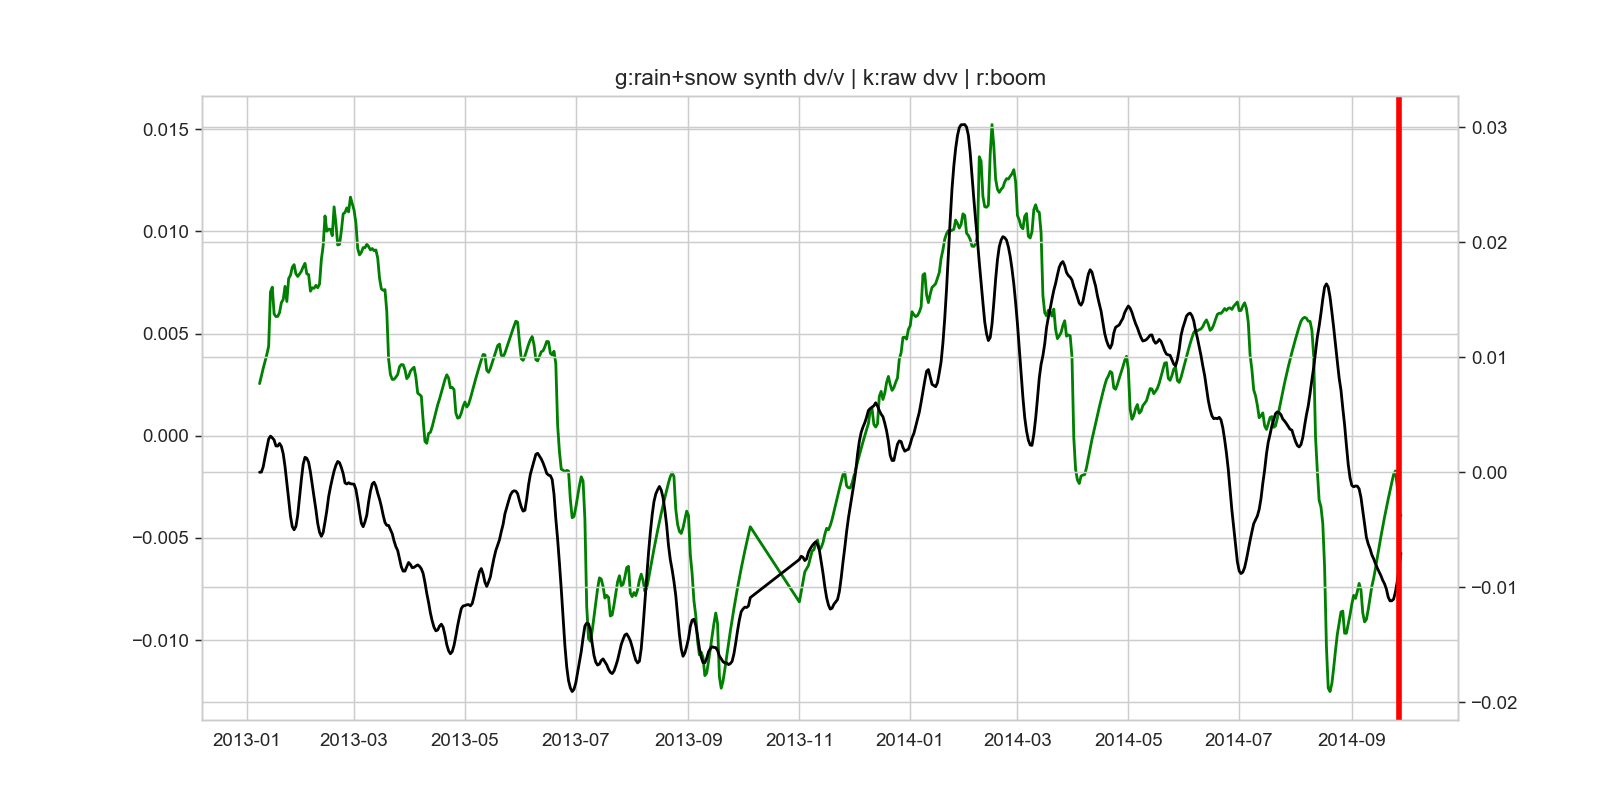

<IPython.core.display.Javascript object>


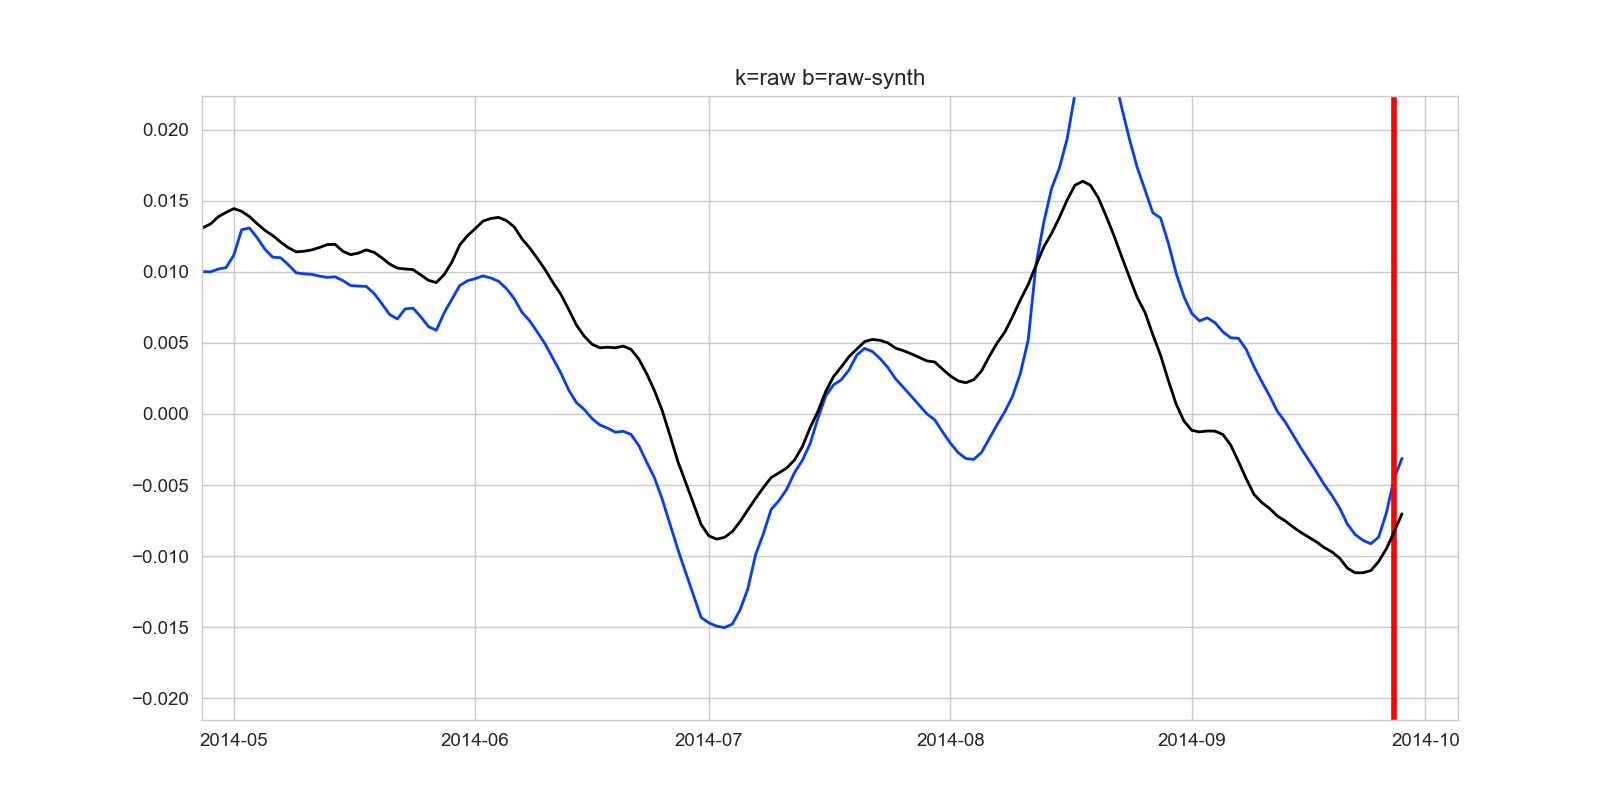

In [19]:
dvv = df["M"]
dvvsynth =  -1*(a * pluvio["P"] + b * pluvio["Snow depth (cm)"])
dvv.to_csv('dvv_data.csv')
plt.plot(pluvio.index, dvvsynth , c="g", label="rain+snow synth dv/v")
plt.twinx()
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

plt.plot(pluvio.index, dvv-dvvsynth )

plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=raw-synth")
plt.show()


<IPython.core.display.Javascript object>


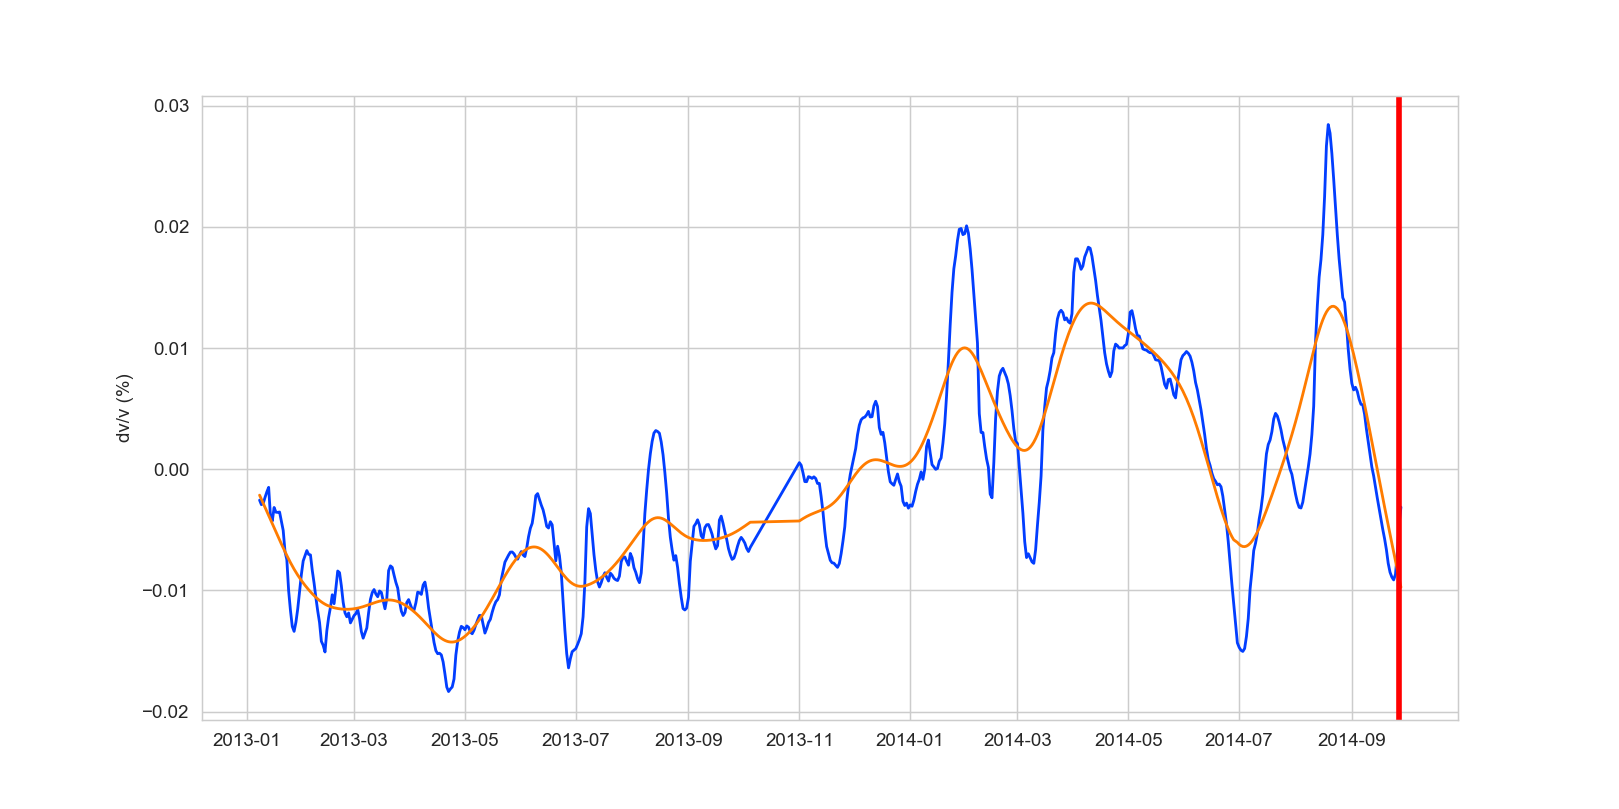

In [20]:
plt.plot(pluvio.index, dvv-dvvsynth )
c,t = hpfilter(dvv-dvvsynth, 10000)
plt.plot(pluvio.index, t)
plt.ylabel("dv/v (%)")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

# read events

In [21]:
def read_event_catalog(file, tz=0):
    names = ["Year","Month","Day","Hour","Minute","Second","Latitude","Longitude","Depth","Magnitude"]
    events = pd.read_csv(file, header=None, names=names, delim_whitespace=True)
    dt = [datetime.datetime(2000+int(r["Year"]),int(r["Month"]),int(r["Day"]),int(r["Hour"]),int(r["Minute"]))+datetime.timedelta(r["Second"]) for id, r in events.iterrows()]
    if tz != 0:
        dt = [d-datetime.timedelta(hours=tz) for d in dt]
    events.index = pd.DatetimeIndex(dt)
    for _ in ["Year","Month","Day","Hour","Minute","Second"]:
        del events[_]
    events = events.sort_index()
    return events

In [22]:
VT = read_event_catalog("ontake_hypo.MAD100", tz=9)
LP = read_event_catalog("ontake_hypoLP.MAD130", tz=9)

<IPython.core.display.Javascript object>


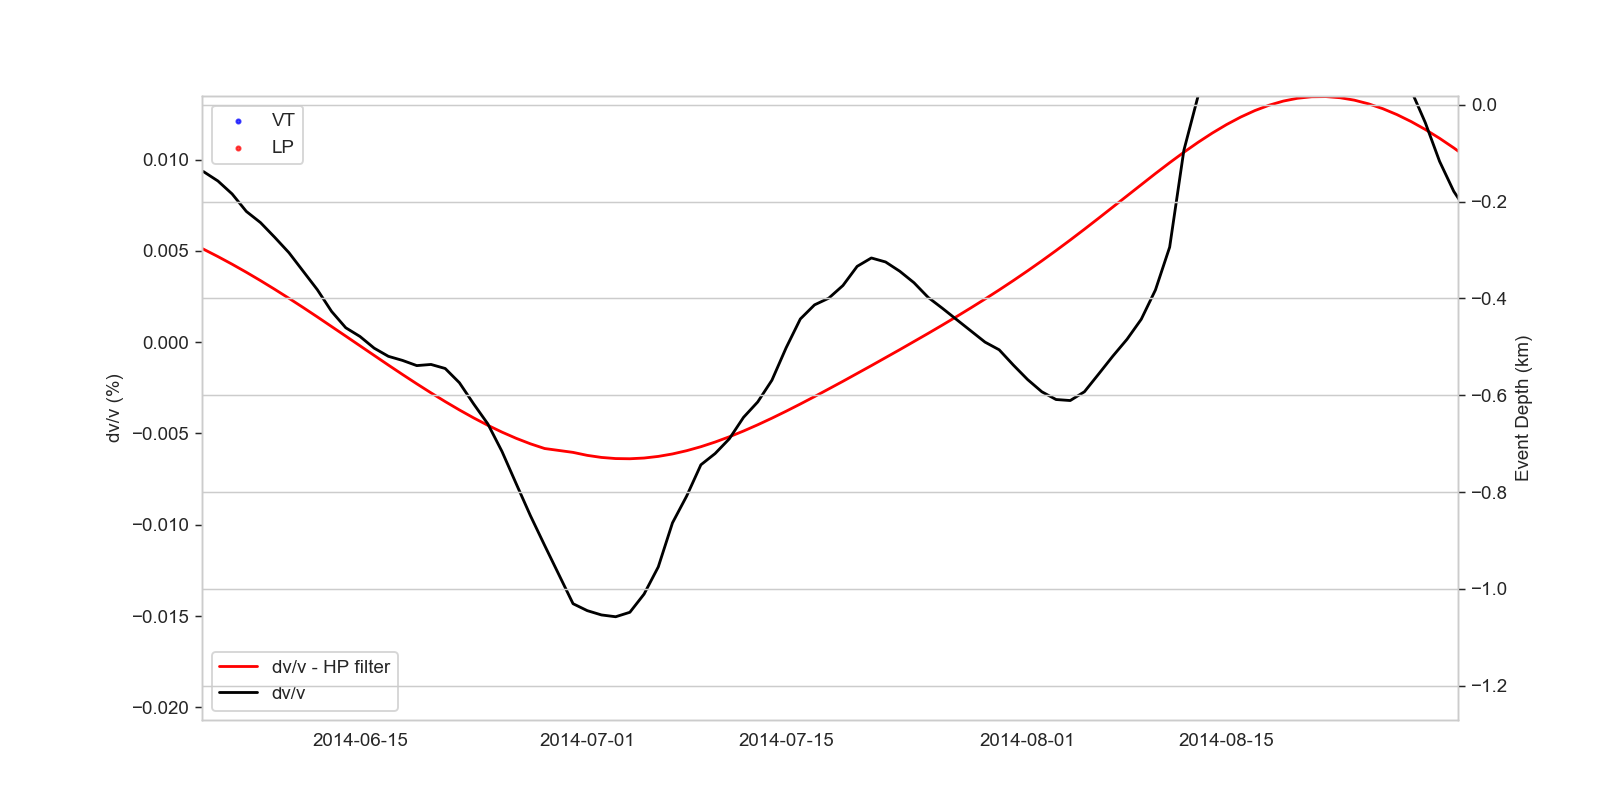

In [23]:
plt.plot(pluvio.index, t, label="dv/v - HP filter", c='r')
plt.plot(pluvio.index, dvv-dvvsynth, label="dv/v", c='k' )
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.grid(False)
plt.ylabel("dv/v (%)")
plt.legend(loc=3)
plt.twinx()
plt.scatter(VT.index, VT["Depth"], label="VT", s=5,alpha = 0.7,c='b')
plt.scatter(LP.index, LP["Depth"], c='r', label="LP",s=5,alpha = 0.7)
plt.legend(loc=3)
plt.ylabel("Event Depth (km)")


plt.legend(loc=2)
plt.savefig('Fig4.pdf',dpi=300)
plt.show()

In [ ]:
VT["type"] = "VT"
LP["type"] = "LP"
events= pd.concat((VT,LP))
print(events.head())

In [ ]:
events.to_csv("ListEvents_WithCat.csv")

In [ ]:
VT.index

In [ ]:
dvv = df["M"]
dvvsynth =  -1*(a * pluvio["P"] + b * pluvio["Snow depth (cm)"])


plt.plot(pluvio.index, dvvsynth , c="g", label="rain+snow synth dv/v")
plt.twinx()
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("g:rain+snow synth dv/v | k:raw dvv | r:boom")
plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.show()

plt.plot(pluvio.index, dvv-dvvsynth )

plt.axvline(datetime.datetime(2014,9,27), c='r', lw=3)
plt.plot(dvv.index, dvv , c="k", label="observed dv/v")
plt.title("k=raw b=raw-synth")


ax=plt.twinx()
detec = pd.read_csv(r'C:\Users\caudroco\Documents\Ontake\Nov_2019\template_matching\detections_per_12h.csv',index_col=0, header=0, parse_dates=True)
ax.plot(detec.index,detec.detect_val,c='k')


plt.show()





In [23]:
### stress transfer

# m/s
vel = 10e-3
# 36 km between 
distance = 36000

time = (distance/vel)/(3600*24)
print(time)

41.666666666666664


In [25]:
# m/s
time = (3600*24*30)
# 36 km between 
distance = 36000

vel = (distance/time)
print(vel)

0.013888888888888888
